# In this Notebook, my implementation of the recommending algorithm will be running
I am born in november, so the main focus will be on Data Analysis the second one on explainability and performance will be more or less irrelevant.



### In the first Cell we can find all necessary imports


In [21]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sn
print('imports done!')

imports done!


### Now we can easily download the Dataset from the grouplens-Website

Before we extract the file, we check if the directory already exists, if so we do not extract the file

In [13]:
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
)

movielens_zipped_file = keras.utils.get_file(
    "ml-100k.zip", movielens_data_file_url, extract=False
)

keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-100k"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")
print(keras_datasets_path)

C:\Users\hp\.keras\datasets


Additionally we will need the United States Zip Codes. For this we need to download them at https://www.unitedstateszipcodes.org/zip-code-database/. They have to be later put into the keras dataset folder, this path is printed in the cell above. It is sufficient to use the Free version. We also need to read the data using pandas and dropping all "not vital" data. Which will be most, because we will only need the Zip-Code and the State.

In [24]:
zip_code_cols = ['zip','type','decommissioned','primary_city','acceptable_cities','unacceptable_cities','state','county','timezone','area_codes','world_region','country','latitude','longitude','irs_estimated_population']
zip_code_dir = keras_datasets_path / "zip_code_database.csv"
zip_codes_df = pd.read_csv(zip_code_dir, sep = ',', names= zip_code_cols, encoding='latin-1')
zip_codes_df.drop([0], inplace = True)
zip_codes_df.drop(['type','decommissioned','primary_city','acceptable_cities','unacceptable_cities','county','timezone','area_codes','world_region','country','latitude','longitude','irs_estimated_population'], axis = 1, inplace = True)
zip_codes_df.head(20)
#print(len(zip_codes_df))

,zip,state
1,00501,NY
2,00544,NY
3,00601,PR
4,00602,PR
5,00603,PR
6,00604,PR
7,00605,PR
8,00606,PR
9,00610,PR
10,00611,PR


The user data is read by using the pandas.read_csv function and loaded into a dataframe, the columns of each type of information is linked with their Keywords.

In [4]:
user_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
user_data = movielens_dir / "u.user"
users = pd.read_csv(user_data, sep='|', names=user_cols,encoding='latin-1')
print('users done, onto ratings now')

users done, onto ratings now


Same as the user data, the ratings data is read and loaded into a dataframe, but because we have here the information of the timestamp, which we will not need in further Investigation, it can be dropped, so we wont use more space than needed.

By executing this cell, the original head of the dataframe is printed and after the drop again, so we can see that the information is actually deleted.

In [5]:
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings_data = movielens_dir / "u.data"
ratings = pd.read_csv(ratings_data, sep='\t', names=ratings_cols)
print(ratings.head())
ratings.drop(['timestamp'], axis=1, inplace=True)
print(ratings.head())
print('ratings done, onto movies now')

   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596
   user_id  movie_id  rating
0      196       242       3
1      186       302       3
2       22       377       1
3      244        51       2
4      166       346       1
ratings done, onto movies now


The movie data is also loaded into a dataframe and the attributes "IMDb_URL" and "video_release_date" get dropped. "IMDb_URL" because we have no need for this information and "video_release_date" because it is mostly not used.

The attribute "release_date" however has most times just the first of january as its date, so it can (and should for validity reasons) be stripped down to just the year. (See lines 7 & 8)

To Save disc space, we also change the datatype for the genres, which are already meant as a Boolean, from int64 to boolean.

In [38]:
movie_cols = ['movie_id','movie_title','release_date','video_release_date','IMDb_URL','unknown',\
          'Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama',\
          'Fantasy','Film_Noir','Horror','Musical','Mystery','Romance','Sci_Fi','Thriller','War','Western']
movie_data = movielens_dir / "u.item"
movies = pd.read_csv(movie_data, sep='|', names=movie_cols, encoding='latin-1')
movies.drop(['IMDb_URL','video_release_date'], axis=1, inplace=True)
movies['release_date'] = pd.to_datetime(movies['release_date'])
movies['release_date'] = movies['release_date'].dt.year
#pd.to_numeric(movies['release_date'], errors='ignore')
movies['release_date'] = movies['release_date'].astype('int64',errors='ignore')
is_non_numeric = pd.to_numeric(movies['release_date'], errors='coerce').isnull()

movies.iloc[:, 'release_date':] = movies.iloc[:, 'release_date':].astype(bool)
movies.sort_values(by='release_date', inplace=True)
print(movies.head(10))
movie_ratings = pd.merge(movies, ratings)
df_all = pd.merge(movie_ratings, users)
print('all done and merged')
print(movies.dtypes)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [11]:
zip_codes = df_all['zip_code'].to_numpy()
print(zip_codes)

['15235' '15235' '15235' ... '22030' '22030' '22030']


In [7]:
df_all.sort_values(by='movie_id', inplace=True)
print(df_all.head())

       movie_id       movie_title  release_date  unknown  Action  Adventure  \
48210         1  Toy Story (1995)        1995.0        0       0          0   
93388         1  Toy Story (1995)        1995.0        0       0          0   
95779         1  Toy Story (1995)        1995.0        0       0          0   
45022         1  Toy Story (1995)        1995.0        0       0          0   
14160         1  Toy Story (1995)        1995.0        0       0          0   

       Animation  Children  Comedy  Crime  ...  Sci_Fi  Thriller  War  \
48210          1         1       1      0  ...       0         0    0   
93388          1         1       1      0  ...       0         0    0   
95779          1         1       1      0  ...       0         0    0   
45022          1         1       1      0  ...       0         0    0   
14160          1         1       1      0  ...       0         0    0   

       Western  user_id  rating  age  gender     occupation  zip_code  
48210        0

In [8]:
df_all.describe()

,movie_id,release_date,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,user_id,rating,age
count,100000.000000,99991.000000,100000.0000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000
mean,425.530130,1987.956216,0.0001,0.255890,0.137530,0.036050,0.071820,0.298320,0.080550,0.007580,...,0.049540,0.052450,0.194610,0.12730,0.21872,0.093980,0.018540,462.48475,3.529860,32.969850
std,330.798356,14.155523,0.0100,0.436362,0.344408,0.186416,0.258191,0.457523,0.272144,0.086733,...,0.216994,0.222934,0.395902,0.33331,0.41338,0.291802,0.134894,266.61442,1.125674,11.562623
min,1.000000,1922.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,1.00000,1.000000,7.000000
25%,175.000000,1986.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,254.00000,3.000000,24.000000
50%,322.000000,1994.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,447.00000,4.000000,30.000000
75%,631.000000,1996.000000,0.0000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,682.00000,4.000000,40.000000
max,1682.000000,1998.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,943.00000,5.000000,73.000000


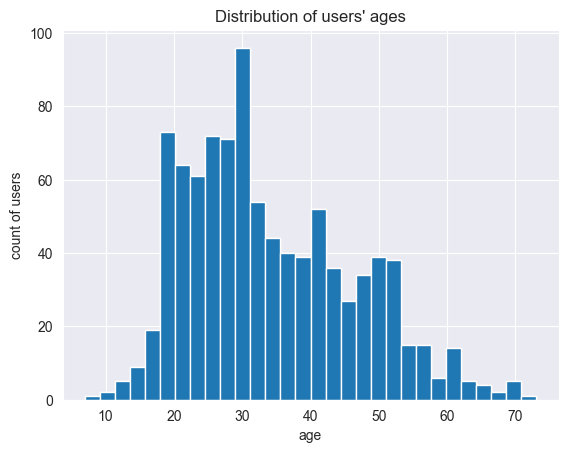

In [9]:
# The 30 most rated movies
most_rated = df_all.groupby(by = 'movie_title').size().sort_values(ascending=False)[:30]
#lens.movie_title.value_counts()[:30]

movie_stats = df_all.groupby('movie_title').agg({'rating': [np.size, np.mean]}).sort_values([('rating', 'mean')], ascending=False)

rate_atleast_200 = movie_stats['rating']['size'] >= 200
movie_stats[rate_atleast_200].sort_values([('rating', 'mean')],ascending=False)

most_50 = df_all.groupby('movie_title').size().sort_values(ascending=False)[:50]

plt.figure()
sn.histplot(users['age'],bins = 30)
plt.title("Distribution of users' ages")
plt.ylabel('count of users')
plt.xlabel('age')

plt.hist(users['age'],bins=30)
plt.title("Distribution of users' ages")
plt.ylabel('count of users')
plt.xlabel('age')

labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
df_all['age_group'] = pd.cut(df_all.age, range(0, 81, 10), right=False, labels=labels)
df_all.groupby('age_group').agg({'rating': [np.size, np.mean]})
df_all.set_index('movie_title', inplace=True)

by_age = df_all.loc[most_50.index].groupby(['movie_title', 'age_group'])
by_age = by_age.rating.mean().unstack(1).fillna(0)

df_all.reset_index(inplace=True)
df_all.set_index('movie_title', inplace=True)

pivoted = df_all.pivot_table(index=['movie_title'],
                           columns=['gender'],
                           values='rating',
                           fill_value=0)

# First steps in deep learning

## Daten laden:
## Normieren:
## Modell erstellen: bzw Netz erstellen
Mit einem pretrained Model starten und darauf aufbauen und das neural network erweitern
### Flatten Layer:
nimmt Matrizen und erstellt daraus einen eindimensionalen Vektor mit den "Zeilen" hintereinander
### Dense Layer:
fully connected Layer, macht aus x Eingaben y Ausgabeparameter, ist zwar langsam aber dafür sehr präzise
### Output-Layer:
10 Möglichkeiten, je nach gewichtung wird ein Ausgang beim MNIST gewählt.
Für Movielens den Sigmoid ans Ende packen.
## Modell kompilieren:
Tensorflow-Ding
definiert optimizer (wie macht mans besser), Loss (Loss-Funktion) und Metrik (Was wird als gut bewertet)
## modell trainieren:
model.fit

## Modell predicten
kann man auch bezüglich der Fehler prüfen, z.B.: warum wurde das nicht erkannt?
model.predict(np.expand_dims(x_validation[10],0))
mit round drumherum geht es auf 1 bzw 0
## modell validieren:


anregungen vom 8.12.:

nicht bloaten,
data analysis; was genau haben wir da und auch nach split beachten, welche params wichtig sind und welche nicht
beachten und nichtbeachten von verteilungen und geografischen Angaben.